# Image Classification with CNN using Tensorflow
Mason Phung

Last update:

In [23]:
# Load libraries
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from src import config

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import preprocessing
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom

## I. Data exploration and preparation

- The dataset used in the work is Intel Image Classification from Kaggle: https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download
- The data has been divided into train/pred/test sets.
- After downloading them, we'll extract the zip file, then directly access the unzip folder.


### A. Exploration

**1. Let's assign the list of available classes to a variable with name `CLASS_NAMES`. For each class name, display one image and print the dimensions of the corresponding numpy array.**
- Set the directory path, the train/test set path.
- In the given directory, iterates over each `pathname` found and extract its base name.
- Exclude any `pathname` found that includes ".", which is usually the type part of filenames ().

In [24]:
# Assign the location path of the dataset
# Assign the location path of the dataset
data_path = config.data_path

# Set the dataset paths
train_path = config.train_path
test_path = config.test_path
pred_path = config.pred_path

# Determine frequently used constants
image_size = config.image_size
img_height = config.img_height
img_width = config.img_width
img_channels = config.img_channels
batch_size = config.batch_size
class_names = config.class_names
print("All classes found in the directory:", class_names)

All classes found in the directory: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


- Loop thorugh each item of the class list to print the image.
- Determine the image and its dimension through its path.
- Print the class name together with the dimension as the image title.

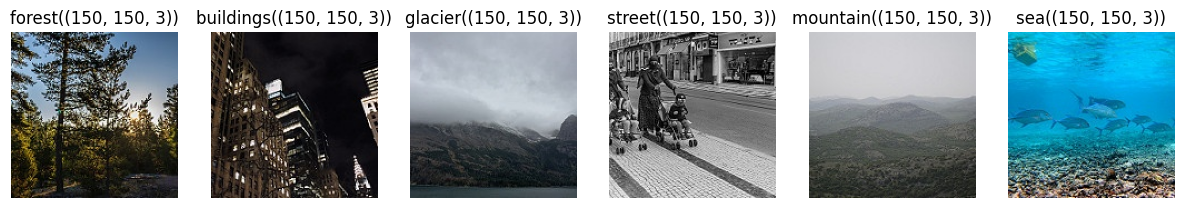

In [25]:
# Set up a plot grid of 1 row, length is based on the number of classes
count, ax = plt.subplots(1, len(class_names), figsize=(15,15))

# Enumerate through the list of classes to print one image of each
for idx, each in enumerate(class_names):
    # Take the first image of each class
    img_path = glob.glob(f'{train_path}/{each}/*')[0] # Feel free to change this number to observe other images !!
    # Read the image
    img = plt.imread(img_path)
    # Find the dimensions
    img_dimension = np.array(img)
    # Print the image by adding it into the grid
    ax[idx].imshow(img)
    ax[idx].set_title(f'{class_names[idx]}({img_dimension.shape})')
    ax[idx].axis('off')

**2. Determine the number of images in the training and test sets for each class name**

In [26]:
for count, each in enumerate(class_names):
    # Count the total training & test image of each class
    x = len(glob.glob(f'{train_path}/{each}/*'))
    y = len(glob.glob(f'{test_path}/{each}/*'))
    # Print the results
    print(
        f"Class: {each}","\n",
        "Number of train images: ", x,"\n",
        "Number of test images: ", y ,"\n",
        "Ratio: ", round((y/(x+y)), 2),"\n"
    )

Class: forest 
 Number of train images:  2271 
 Number of test images:  474 
 Ratio:  0.17 

Class: buildings 
 Number of train images:  2191 
 Number of test images:  437 
 Ratio:  0.17 

Class: glacier 
 Number of train images:  2404 
 Number of test images:  553 
 Ratio:  0.19 

Class: street 
 Number of train images:  2382 
 Number of test images:  501 
 Ratio:  0.17 

Class: mountain 
 Number of train images:  2512 
 Number of test images:  525 
 Ratio:  0.17 

Class: sea 
 Number of train images:  2274 
 Number of test images:  510 
 Ratio:  0.18 



<span style="color:red">

- *There are not many differences between the proportion of train/test sets between each class. Notice that class `glacier` as a slight bigger amount of test images compared to other classes.*
- *We have a balance data set as the counts of each class in train and test sets are quite similar.*

</span>

### B. Data Preparation

Use TensorFlow's `image_dataset_from_directory` to generate datasets for training, validation, and test. We'll following options:

- Image size: 150 x 150 and 3 channels
- Colour mode = RGB
- Shuffle = True
- Seed = 1234
- Labels = inferred
- Class names = class_names
- Label mode = int
- Batch size = 32

- We set the image size, colour mode to match the properties of the images.
- Set the class names of the images, use the label mode as integer, set `labels = inferred` as we get the labels from the folder names (in the directory).
- Use a batch size of 32.

In [27]:
# Process the images into TF datasets
(train_set, validation_set) = preprocessing.image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    label_mode = 'int',
    class_names = class_names,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 1234,
    validation_split = 0.2,
    subset = 'both',
)

test_set = preprocessing.image_dataset_from_directory(
    test_path,
    labels = 'inferred',
    label_mode = 'int',
    class_names = class_names,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 1234,
)

# Normalize image data
def process(image, label):
    """
    Normalizes image data and casts it to float32.

    Parameters:
        image (Tensor): Input image tensor with pixel values in the range [0, 255].
        label (Tensor): Corresponding label tensor for the image.

    Returns:
        image, label (Tuple): Normalized image tensor with pixel values in the range [0, 1], and the corresponding label tensor.
    """
    image = tf.cast(image / 255. ,tf.float32)
    return image, label

train_set = train_set.map(process)
validation_set = validation_set.map(process)
test_set = test_set.map(process)

# Save the datasets
train_set.save('data/processed/train_set')
validation_set.save('data/processed/validation_set')
test_set.save('data/processed/test_set')

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


**Set up early stopping**

To save resources, it is important to stop the training when the model is no longer working fine. We determine this using `val_loss`, which is the loss of the model on the validation set. If the loss increases, after a certain of epochs, the model will stop training.
- Evaluation the loss of validation data with `val_loss`.
- Set `min_delta = 0`: Look at the loss when it gets worse.
- `Patience = 3`: Stop at the number of epochs after the loss starts to get worse.

In [28]:
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

### C. Create useful functions

Create function `plot_accuracy_loss` to plot this accuracy and loss of the model on both training and validation set.

In [29]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the neural network
    
    Parameters:
        history: A History object returned by the fit method of a Keras model. It contains the training and validation loss and accuracy for each epoch.
    
    Returns:
        A plt plot presents the training and validation loss and accuracy.
    """
    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='val_Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(len(history.history['loss'])))

    plt.subplot(4, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(len(history.history['accuracy'])))

    return plt.show()

## II. Model training



### A. Fine tuned a Conv2D model

We tune the number of layers and the number of Conv2D layers inside it. Let's call the large layer 'batch' and layers inside each batch 'layers'. Use `keras-tuner` and tune among these parameters:
- Number of batches (1-5 batches)
- Number of hidden layers (1-5 layers)
- Conv2D layers:
    - The size of filters (32-256)
    - Kernel size (3 or 5)
- Dense layers: Sizes of hidden layers (32-512 units)
- Dropout rate (0 - 0.9)
- Learning rate (1e-4 - 1e-2)

The rest of the hyperparameters are set based on the properties of the data.

**Set up data augmentation**

- To help increase the accuracy score, it is better to increase the number of data we have. Utilizing data augmentation certainly helps achieving it.

- Data augmentation randomly transforms the existing images, create new instances of the images based on the ones we have.

- We will do random horizontal flip, rotation and zoom to the images.

In [32]:
# Define `build_model` to build the deep NN model
def build_model(hp):
    """
    Returns a compiled keras neural network model with a search space initialized with
    to-be-tuned hyperparameters.
    
    Parameters:
        hp (HyperParameters class): Define the hyperparameters when building the model
    
    Returns:
        model (keras.models.Sequential): The constructed & compiled Keras model.
    """
    model = keras.Sequential()
    # Add the Input layer
    model.add(Input(shape = (img_height, img_width, img_channels)))
    # Add data augmentation layers
    model.add(RandomFlip('horizontal'))
    model.add(RandomRotation(0.1))
    model.add(RandomZoom(0.2))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
    # Tuning the number of layers
    num_batches = hp.Int('num_batches', min_value=1, max_value=5, step=1)        
    for i in range(num_batches):
        num_layers = hp.Int(f'num_layers_{i+1}', min_value=1, max_value=3, step=1)
        for _ in range(num_layers):
            # Conv2D layers
            model.add(Conv2D(
                filters = hp.Int(f'conv_filter_{i+1}', min_value=32, max_value=256, step=32*(i+1)),
                kernel_size = hp.Choice('conv_kernel', values = [3,5]),
                activation = 'relu',
                padding = 'same'
            ))
            # MaxPooling2D layers
            model.add(MaxPooling2D(
                pool_size = (2,2),
                padding = 'same'
            ))    
        # Tune a dropout layer
        dropout_rate = hp.Float(f"dropout_rate{i+1}", min_value = 0.1, max_value = 0.5, step = 0.1)
        # Add a dropout layer
        model.add(Dropout(rate = dropout_rate))
        
    # Add a Flatten layer
    model.add(Flatten())
    # Add a Dense model layer
    model.add(Dense(
        units = hp.Int('units', min_value=32, max_value=512, step=32),
        activation = 'relu'
    ))
    # Add a dropout layer
    model.add(Dropout(rate=hp.Float('final_dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    # Add the output layer
    model.add(Dense(units = len(class_names), activation = 'softmax'))
    
    # Tune the learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    # Configure the model to fit the case 
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics = ['accuracy']
    )
    return model

Utilize Bayesian Optimization to search for the best hyperparamters. 

In [33]:
# Set up the tuner class to search
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective = kt.Objective('val_accuracy', 'max'),
    max_trials = 5,
    num_initial_points = 2,
    overwrite = True,
    project_name = 'cnn_fine_tuned'
)

# Take a look at the search space
tuner.search_space_summary()

Search space summary
Default search space size: 8
num_batches (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_layers_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
conv_filter_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_rate1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
final_dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'

In [34]:
# Search for the best hyperparameters
tuner.search(
    train_set,
    validation_data = validation_set,
    epochs = 25,
    callbacks = [early_stopping]
    )

# Print the best hyperparameters and model (Top 1)
topN = 1
for x in range(topN):
    best_hp = tuner.get_best_hyperparameters(topN)[x]
    print(best_hp.values)
    print(tuner.get_best_models(topN)[x].summary())


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
4                 |4                 |num_batches
3                 |3                 |num_layers_1
128               |128               |conv_filter_1
3                 |3                 |conv_kernel
0.4               |0.4               |dropout_rate1
416               |416               |units
0.1               |0.1               |final_dropout_rate
0.00025073        |0.00025073        |lr

Epoch 1/25
 16/351 ━━━━━━━━━━━━━━━━━━━━ 6:23 1s/step - accuracy: 0.1790 - loss: 1.7931

KeyboardInterrupt: 

<span style="color:red">

The model is quite large and complex, this explains the long running time. In a local machine, this is not an efficient option to do.

</span>

**Train the model with the best hyperparameters**

In [ ]:
# Build a new model with the optimal 
optimal_model = build_model(best_hp)
optimal_model.save('fine_tuned_cnn.h5')
print('Model saved!')
optimal_model.save_weights('fined_tuned_cnn_weight.h5')
print('Weights saved!')

In [ ]:
more_complex_model_result = optimal_model.fit(
    train_set,
    validation_data = validation_set,
    epochs = 25,
    callbacks = [early_stopping]
)   

In [27]:
# Predict with the test set
complex_model_test_loss, complex_model_test_acc = optimal_model.evaluate(test_set)
print('Test accuracy of the optimal model:', complex_model_test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5524 - loss: 1.1667
Test accuracy of the optimal model: 0.5556666851043701


- What I did to find a base for the model:
    - First train a Conv2D model with a few simple Conv2D + MaxPooling2D layers and a Flatten + Output layer. Note that keeps each `Conv2D` followed by a `MaxPooling2D` layer.
    - Then, aims to improve the model's reliability and reduce overfitting by adding aditional layers and tuning different metrics. It can be achieved by:
        - Increase model complexity: Adding more layers to the model (Conv2D, MaxPooling2D, Dense). This make the model better understand the data, especially the training data.
        - Adding Dropout layers to help the model to not rely on any specific neuron, reduce overfitting. We'll increase the dropout rate for layers that have a higher number of filters.
        - Implement data augmentation: Increase the amount of data the model have to train, reduce overfitting and improve the model accuracy on unseen data.
    - For Conv2D layers:
        - Initially used 4 layers of `32-64-128-256 filters`, then I increased these numbers but it doesn't work. Then come back to the original numbers of filters but doubled the number of layers.
        - Apply similar `kernel_size = 3`, the model doesn't seem to improve when kernel size changed.
        - Use `activation = 'relu'` as it's suitable for our data and `padding = 'same'` to keep the layer's outputs having the same spatial dimensions as its inputs. Also this will make sure that we will not drop any input just because the number of inputs is odd.
    - Keep the same MaxPooling2D with pool_size = (2,2) as this is the ideal value, it will not reduce our data.

- I tried to overcome underfitting (model works badly on both train/val set), overfitting (model works well on train set but not on val set) by balancing between model complexity and dropout/data augmentation when tuning the model.
- Note that even though I made different tuning attempts to achieve better results, I'll just show the best version to save time.

### B. Use a pre-trained Mobilenet model

- Apply data augmentation, pre-trained MobileNet model with correct classification layer, then an output layer.
- Freeze MobileNet weight wiht `trainable = False` to prevent catastrophic forgetting.

In [44]:
# used to reset the model when tuning
# mobile_model = 1
# mobilenet_model = 1

In [44]:
# Create a pre-trained mobilenet model instance
mobilenet_model = tf.keras.applications.MobileNet(
    weights = "imagenet",
    input_shape = (img_height, img_width, img_channels),
    include_top = False,
    pooling = "avg"
)

for layer in mobilenet_model.layers:
    layer.trainable = False

mobile_model = keras.models.Sequential([
    Input(shape = (img_height, img_width, img_channels)),
    data_augmentation,
    mobilenet_model,
    Dense(len(class_names), activation = 'softmax')
])


mobile_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy']
)

mobile_model.summary()

/var/folders/v2/whcxjrn109q5520vvfscjz_00000gn/T/ipykernel_23727/3426553628.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = tf.keras.applications.MobileNet(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [45]:
mobile_model_results = mobile_model.fit(
    train_set,
    validation_data = validation_set,
    epochs = 10
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.3501 - loss: 1.7819 - val_accuracy: 0.7694 - val_loss: 0.6628
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.7757 - loss: 0.6405 - val_accuracy: 0.8339 - val_loss: 0.4633
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.8192 - loss: 0.5068 - val_accuracy: 0.8599 - val_loss: 0.3924
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.8438 - loss: 0.4297 - val_accuracy: 0.8724 - val_loss: 0.3619
Epoch 5/10
282/351 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8513 - loss: 0.4038

KeyboardInterrupt: 

In [47]:
mobile_model_test_lost, mobile_model_test_acc = mobile_model.evaluate(test_set)
print('Test accuracy of the model:', mobile_model_test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8882 - loss: 0.2969
Test accuracy of the model: 0.8893333077430725


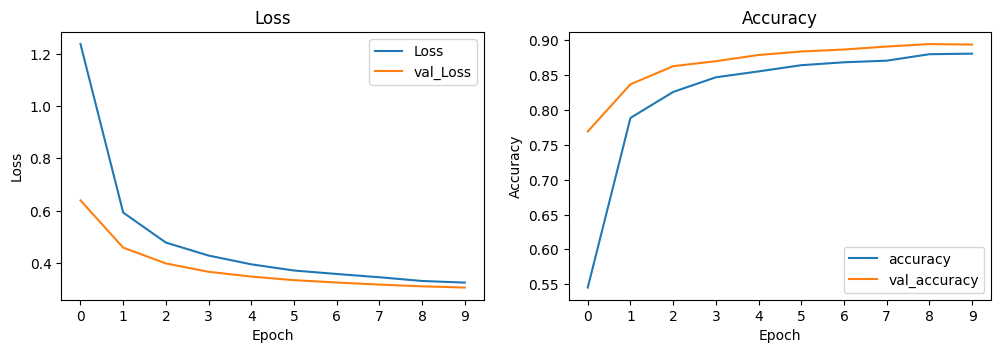

In [48]:
plot_accuracy_loss(mobile_model_results)

<span style="color:red">

The model did a great job, there is always a smaller loss and higher accuracy score on the validation set.

</span>

### C. Comparative Evaluation

Let's compare our two models by looking at the accuracy score, confusion matrix and analyze the error predictions.

In [49]:
# Let's find the accuracy score on the train set
fine_tuned_conv_model_train_loss, fine_tuned_conv_model_train_acc = fine_tuned_conv_model.evaluate(train_set)
mobile_model_train_loss, mobile_model_train_acc = mobile_model.evaluate(train_set)

# Let's find the accuracy score on the validation set
fine_tuned_conv_model_val_loss, fine_tuned_conv_model_val_acc = fine_tuned_conv_model.evaluate(validation_set)
mobile_model_val_loss, mobile_model_val_acc = mobile_model.evaluate(validation_set)


pd.DataFrame.from_records(
    {"Conv model": [fine_tuned_conv_model_train_acc, fine_tuned_conv_model_val_acc, fine_tuned_conv_model_test_acc], "MobileNet model": [mobile_model_train_acc, mobile_model_val_acc, mobile_model_test_acc]},
    index = ["Train Acc Score", "Val Acc Score", "Test Acc Score"]
)

351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7034 - loss: 0.7685
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9011 - loss: 0.2746
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6899 - loss: 0.7716
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9001 - loss: 0.2798


,Conv model,MobileNet model
Train Acc Score,0.710011,0.901140
Val Acc Score,0.683892,0.894155
Test Acc Score,0.698667,0.889333


<span style="color:red">

- Observing the results, we can clearly see that the `MobileNet` model works generally better and is more reliable on classifying the images compared to the `Convolution` model. On unseen images, the scores are always higher for Mobilenet (0.89 - 0.68 on validation set and 0.89 - 0.70 on test set).
- Looking at the accuracy and loss plots of two model, it is also visible that the `MobileNet` model works better over epochs.
- Observing the fitting result (Accuracy/Loss plot), the `MobileNet` model is reliable and has a better result on the validation set.
- Note: The evaluate results by evaluating the trained model on train set is higher (obviously) due to the fact that it is being evaluated on seen data. This is higher than the results of the val/test set but doesn't reflect if the model is actually overfitting or not. Moreover, as the gap between train acc and val/test acc are very small, we have more ground to say that this is not a problem. When observing both models in the accuracy & loss plots by epochs, we can see that their is no overfit sign with the `MobileNet` model, while it happens at early stages of the `Convolution` model.

</span>

**Let's display the confusion matrix of the best system, which is the MobileNet model**

- Generate the true and predicted labels from the test set.
- Calculate the matrix using `sklearn - confusion_matrix`
- Plot the matrix using seaborn

**To get the true and predicted labels**
- As our test set was fetched by using `image_dataset_from_directory`, we need to extract the true and predicted labels by utilizing the test set and the MobileNet model.
- Extract `images` and `labels` batches of the test_set:
    - Get true labels by taking all the labels of `labels`, convert them from tf tensors to np arrays.
    - For predicted labels: Use `argmax` to convert the predicted probabilties from the MobileNet model into class labels.
    - Use `extend()` to add each element of the extracted numpy array of true/predicted labels to the list. We don't use `append()` here as it add the whole array, not each array's item.
    - Extract the test image as np array so we can later plot the images required by the question 3.3.2

In [50]:
y_true = []
y_pred = []
test_images = []

for images, labels in test_set:
    # Append true labels for each batch
    y_true.extend(labels.numpy())
    # Compute predictions for each batch
    preds = mobile_model.predict(images)
    # Append predicted labels for each batch
    y_pred.extend(np.argmax(preds, axis=-1))
    # Append the images for each batch
    test_images.extend(images.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

2024-09-06 15:30:18.726824: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generate the confusion matrix using the predicted and the true labels

In [51]:
# Calculate the confusion matrix
pred_matrix = confusion_matrix(y_true, y_pred)

Plot the confusion matrix

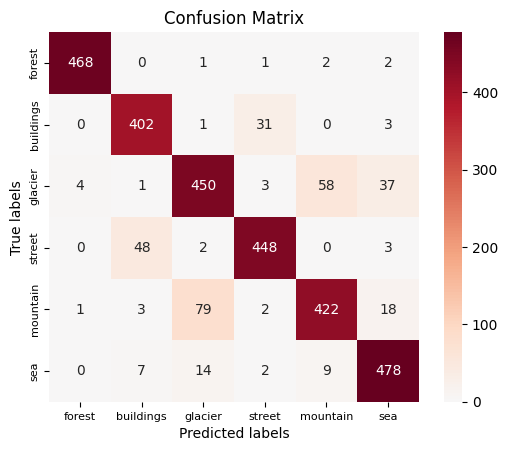

In [52]:
# Plot the confusion matrix
sns.heatmap(
    pred_matrix,
    annot = True,
    fmt = 'd',  # Format annotations as integers
    center = 0,
    square = True,
    cmap = "RdBu_r",
    xticklabels = class_labels,
    yticklabels = class_labels,
)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.tick_params(axis = 'x', labelsize = 8)
plt.ylabel('True labels')
plt.tick_params(axis = 'y', labelsize = 8) 

plt.show()

<span style="color:red">

- The model is having the most problem classifying between `mountain - glacier`, `buildings - streets` with the error ranged between 10-20%
- Similar (but less) problems can also be seen when the model differentiate between these pairs: `sea - glacier`, `sea - mountain`.

</span>

**Display 5 images of the most common type of classificaiton error**

To display the images that represent the error of the classification between `mountain` and `glacier`, we will need the images in the test set and their predicted labels by the mobile_model.
- Make sure to convert the extracted true labels, predicted labels and test image to numpy array.
- As the labels in the test set are integer, we need to determine the int value of the labels so we can use them to extract only the predictions that includes our desired labels. 
- Extract the mislabeled images, pred/true labels by indexing using the defined conditions of desired labels.
- Use matplotlib to plot the images with the extracted mislabeled images and labels.

Number of total mislabeled images: (137,)


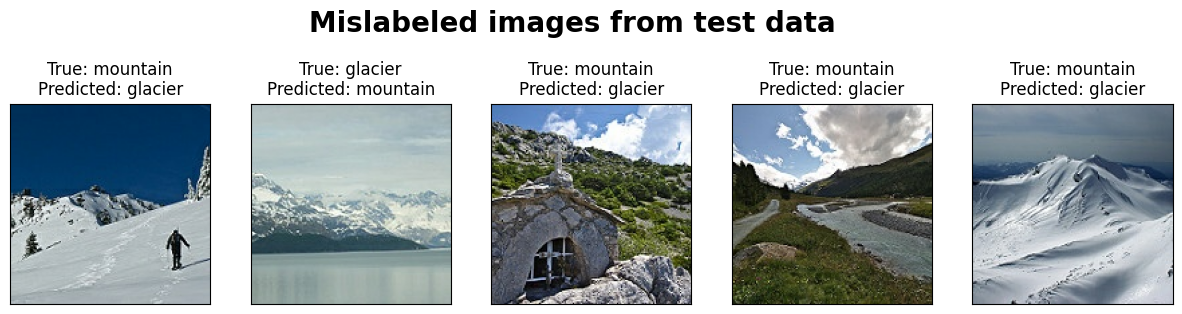

In [53]:
y_true = []
y_pred = []
test_images = []

for images, labels in test_set:
    # Append true labels for each batch
    y_true.extend(labels.numpy())
    # Compute predictions for each batch
    preds = mobile_model.predict(images)
    # Append predicted labels for each batch
    y_pred.extend(np.argmax(preds, axis=-1))
    # Append the images for each batch
    test_images.extend(images.numpy())

# Convert lists to numpy arrays (make sure) - Did in the previous step but can still re-do to make sure
np_true_labels = np.array(y_true)
np_predicted_labels = np.array(y_pred)
np_test_images = np.array(test_images)


# Create mislabeled index
# Determine the position of `mountain` and `glacier` class in class_names
mountain_index = class_names.index('mountain')
glacier_index = class_names.index('glacier')
# Condition for misclassifications where true label is 'mountain' and predicted is 'glacier' or vice versa
mislabeled_mountain_glacier = (np_true_labels == mountain_index) & (np_predicted_labels == glacier_index)
mislabeled_glacier_mountain = (np_true_labels == glacier_index) & (np_predicted_labels == mountain_index)
# Combine both conditions
mislabeled_index = np.where(mislabeled_mountain_glacier | mislabeled_glacier_mountain)[0]


# Extract the mislabeled images, predicted labels, and true labels
mislabeled_images = np_test_images[mislabeled_index]
mislabeled_predicted_labels = np_predicted_labels[mislabeled_index]
mislabeled_true_labels = np_true_labels[mislabeled_index]

# Show the number of total mislabeled images in the classification error pair
print("Number of total mislabeled images:", mislabeled_predicted_labels.shape)

# Plot the first 5 mislabeled images
plt.figure(figsize=(15, 4))
for idx, label in enumerate(mislabeled_predicted_labels[:5]):
    plt.subplot(1, 5, idx+1)
    plt.imshow(mislabeled_images[idx])
    plt.xticks([])
    plt.yticks([])
    # Add the true label and predicted labels to the title
    true_label_name = class_names[mislabeled_true_labels[idx]]
    predicted_label_name = class_names[label]
    plt.title(f'True: {true_label_name}\nPredicted: {predicted_label_name}')
plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
plt.show()

<span style="color:red">

- Observing these images, we can conclude that even we can mistakenly classify them too !

- We can always try to reduce these prediction mistakes by tuning models or adding more data for the model to learn.

</span>

### References (Aside from keras documentation page and course slides, lecture/practical notebooks)

*In this assignment, I utilized GitHub Copilot extension in VSCode to support fixing github versioning problems, detecting (syntax) errors and further explain/differentiate metrics, functions of Keras and Tensorflow.*

Normalize data   
https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3

Generate confusion matrix from prefetched data   
https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matrix

References for model building, mislabeled image generation   
https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras

Hyperparameter tuning   
https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t   
https://stackoverflow.com/questions/71255862/why-do-we-use-maxpooling-2x2-can-we-use-any-other-size-like-3x3-or-5x5-and-how#:~:text=Obviously%20(2%2C2%2C1,a%20better%20option%20to%20choose.   
https://stackoverflow.com/questions/65023353/difference-between-keras-metrics-accuracy-and-accuracy

Better understanding overfitting of Conv models   
https://www.analyticsvidhya.com/blog/2024/04/understanding-overfitting-in-convnets/#